# Setup

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, ReLU, \
                                        Lambda, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, \
                    classification_report, confusion_matrix

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

plt.style.use('ggplot')

# Data

## loading reliable data

In [ ]:
reliable_data_features = np.load("data/sampled/reliable/reliable_samples.npy")
reliable_data_labels = np.load("data/sampled/reliable/reliable_pseudo_labels.npy")

print("reliable data features shape", reliable_data_features.shape)
print("reliable data labels shape", reliable_data_labels.shape)

reliable data features shape (41425, 51200)
reliable data labels shape (41425,)


Class 0: 33583 samples
Class 1: 2383 samples
Class 2: 4414 samples
Class 3: 689 samples
Class 4: 356 samples


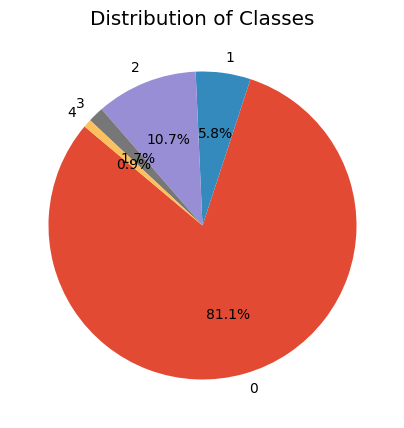

In [ ]:
unique_classes, class_counts = np.unique(reliable_data_labels, return_counts=True)

for class_name, count in zip(unique_classes, class_counts):
    print(f"Class {class_name}: {count} samples")

# Plotting the pie chart
plt.figure(figsize=(5, 5))
plt.pie(class_counts, labels=unique_classes, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Classes')
plt.show()

## Balancing via SMOTE

In [ ]:
features = reliable_data_features
labels = reliable_data_labels

In [ ]:
# Set the target number of samples for each class
target_samples = 7000

# Upsample the minority classes (classes 1, 2, 3, and 4) using SMOTE
smote = SMOTE(sampling_strategy={1: 10000, 2: 15000, 3: target_samples, 4: target_samples})
oversampled_features, oversampled_labels = smote.fit_resample(features, labels)

# Downsample the majority class (class 0) using RandomUnderSampler
undersampler = RandomUnderSampler(sampling_strategy={0: 20000})
undersampled_features, undersampled_labels = undersampler.fit_resample(oversampled_features, oversampled_labels)

print("Class distribution after balancing:", Counter(undersampled_labels))
print("Shape of oversampled features:", undersampled_labels.shape)
print("Shape of oversampled labels:", undersampled_labels.shape)

Class distribution after balancing: Counter({0: 20000, 2: 15000, 1: 10000, 3: 7000, 4: 7000})
Shape of oversampled features: (59000,)
Shape of oversampled labels: (59000,)


In [ ]:
os.makedirs('data/experiments/experiment1/', exist_ok=True)

np.save("data/experiments/experiment1/balanced_features.npy", undersampled_features)
np.save("data/experiments/experiment1/balanced_labels.npy", undersampled_labels)

print("Features saved at data/experiments/experiment1/balanced_features.npy")
print("Labels saved at data/experiments/experiment1/balanced_labels.npy")

Features saved at data/experiments/experiment1/balanced_features.npy
Labels saved at data/experiments/experiment1/balanced_labels.npy


## Data Split

In [ ]:
balanced_features = np.load('data/experiments/experiment1/balanced_features.npy')
balanced_labels = np.load('data/experiments/experiment1/balanced_labels.npy')

print("Class distribution:", Counter(balanced_labels))
print("Shape of balanced features:", balanced_labels.shape)
print("Shape of balanced labels:", balanced_labels.shape)

Class distribution: Counter({0: 20000, 2: 15000, 1: 10000, 3: 7000, 4: 7000})
Shape of balanced features: (59000,)
Shape of balanced labels: (59000,)


In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(
    balanced_features, balanced_labels, test_size=0.25, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42
)

print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_val shape", X_val.shape)
print("y_val shape", y_val.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train shape (44250, 51200)
y_train shape (44250,)
X_val shape (11800, 51200)
y_val shape (11800,)
X_test shape (2950, 51200)
y_test shape (2950,)


In [ ]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [ ]:
np.save('data/experiments/experiment1/X_train.npy', X_train)
np.save('data/experiments/experiment1/y_train.npy', y_train)

np.save('data/experiments/experiment1/X_val.npy', X_val)
np.save('data/experiments/experiment1/y_val.npy', y_val)

np.save('data/experiments/experiment1/X_test.npy', X_test)
np.save('data/experiments/experiment1/y_test.npy', y_test)

# Training final model on Reliable dataset

In [ ]:
X_train = np.load('data/experiments/experiment1/X_train.npy')
y_train = np.load('data/experiments/experiment1/y_train.npy')

X_val = np.load('data/experiments/experiment1/X_val.npy')
y_val = np.load('data/experiments/experiment1/y_val.npy')

In [ ]:
model = Sequential([
    Dense(1024, input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.2),
    ReLU(),

    Dense(512),
    BatchNormalization(),
    Dropout(0.2),
    ReLU(),

    Dense(256),
    BatchNormalization(),
    Dropout(0.2),
    ReLU(),

    Dense(5, activation='softmax')
])

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


history = model.fit(
    X_train, y_train,
    epochs=30,
    validation_data=(X_val, y_val)
)

Epoch 1/30
1383/1383 [==============================] - 39s 24ms/step - loss: 0.7718 - accuracy: 0.6845 - val_loss: 0.4942 - val_accuracy: 0.7975
Epoch 2/30
1383/1383 [==============================] - 28s 20ms/step - loss: 0.4205 - accuracy: 0.8364 - val_loss: 0.3846 - val_accuracy: 0.8508
Epoch 3/30
1383/1383 [==============================] - 28s 20ms/step - loss: 0.2940 - accuracy: 0.8886 - val_loss: 0.3538 - val_accuracy: 0.8681
Epoch 4/30
1383/1383 [==============================] - 28s 20ms/step - loss: 0.2252 - accuracy: 0.9156 - val_loss: 0.2390 - val_accuracy: 0.9122
Epoch 5/30
1383/1383 [==============================] - 28s 20ms/step - loss: 0.1793 - accuracy: 0.9335 - val_loss: 0.2614 - val_accuracy: 0.9052
Epoch 6/30
1383/1383 [==============================] - 28s 20ms/step - loss: 0.1499 - accuracy: 0.9450 - val_loss: 0.2727 - val_accuracy: 0.9056
Epoch 7/30
1383/1383 [==============================] - 28s 20ms/step - loss: 0.1262 - accuracy: 0.9535 - val_loss: 0.2249 -

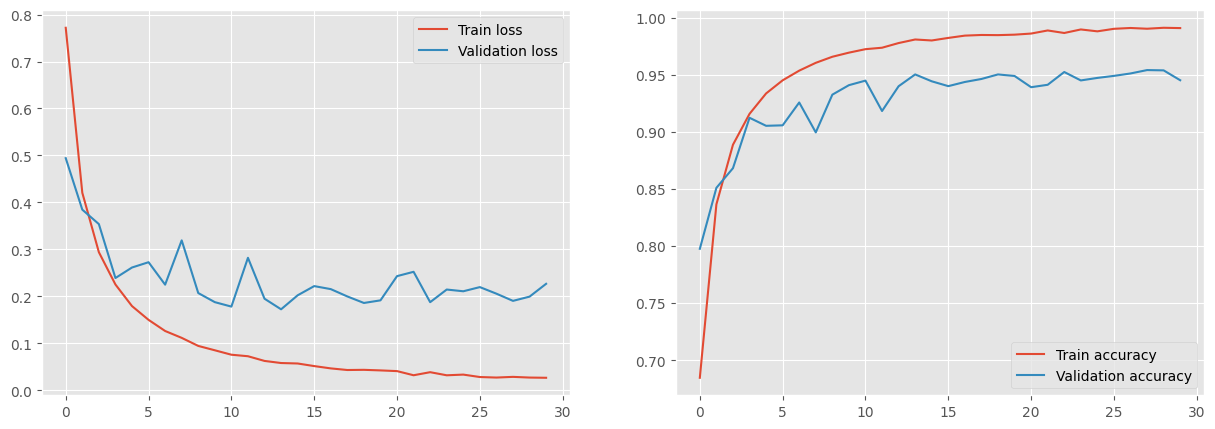

In [ ]:
r = pd.DataFrame(history.history)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(r.index, r['loss'], label='Train loss')
ax[0].plot(r.index, r['val_loss'], label='Validation loss')
ax[1].plot(r.index, r['accuracy'], label='Train accuracy')
ax[1].plot(r.index, r['val_accuracy'], label='Validation accuracy')
ax[0].legend()
ax[1].legend()
plt.show()

In [ ]:
X_test = np.load('data/experiments/experiment1/X_test.npy')
y_test = np.load('data/experiments/experiment1/y_test.npy')

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

y_test = np.argmax(y_test, axis=1)

93/93 [==============================] - 1s 5ms/step


In [ ]:
# Calculate precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the results
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

Accuracy: 0.9444067796610169
Precision: 0.9464260454276939
Recall: 0.9444067796610169
F1 score: 0.9439590098099417


In [ ]:
model.save('data/experiments/experiment1/model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Testing

In [ ]:
model = tf.keras.models.load_model('data/experiments/experiment1/model.h5')

## Testing Reliable dataset

In [ ]:
reliable_data_features = np.load("data/sampled/reliable/reliable_samples.npy")
reliable_data_labels = np.load("data/sampled/reliable/reliable_pseudo_labels.npy")

print("Reliable data Class distribution:", Counter(reliable_data_labels))
print("reliable data features shape", reliable_data_features.shape)
print("reliable data labels shape", reliable_data_labels.shape)

Reliable data Class distribution: Counter({0: 33583, 2: 4414, 1: 2383, 3: 689, 4: 356})
reliable data features shape (41425, 51200)
reliable data labels shape (41425,)


In [ ]:
reliable_data_labels_cat = to_categorical(reliable_data_labels)

In [ ]:
loss, acc = model.evaluate(reliable_data_features, reliable_data_labels_cat)

print('Reliable Accuracy:', acc)
print('Reliable loss', loss)

1295/1295 [==============================] - 55s 42ms/step - loss: 0.2357 - accuracy: 0.9416
Reliable Accuracy: 0.9416294693946838
Reliable loss 0.23569907248020172


In [ ]:
y_pred = model.predict(reliable_data_features)
y_pred = np.argmax(y_pred, axis=1)

y_test = np.argmax(reliable_data_labels_cat, axis=1)

1295/1295 [==============================] - 54s 42ms/step


In [ ]:
# Calculate precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the results
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

Accuracy: 0.9416294508147254
Precision: 0.9534670509517239
Recall: 0.9416294508147254
F1 score: 0.9443255911143754


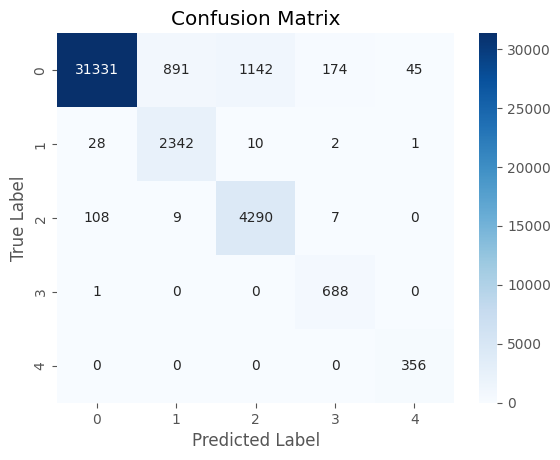

In [ ]:
# Confusion Matrix

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     33583
           1       0.72      0.98      0.83      2383
           2       0.79      0.97      0.87      4414
           3       0.79      1.00      0.88       689
           4       0.89      1.00      0.94       356

    accuracy                           0.94     41425
   macro avg       0.84      0.98      0.90     41425
weighted avg       0.95      0.94      0.94     41425



## Testing Unreliabe samples

In [ ]:
unreliable_data_features = np.load("data/sampled/unreliable/unreliable_data_features.npy")
unreliable_data_labels = np.load("data/sampled/unreliable/unreliable_pseudo_labels.npy")

print("Unreliable data Class distribution:", Counter(unreliable_data_labels))
print("Unreliable data features shape", unreliable_data_features.shape)
print("Unreliable data labels shape", unreliable_data_labels.shape)

Unreliable data Class distribution: Counter({1: 3059, 2: 2486, 0: 2270, 4: 2258, 3: 2072})
Unreliable data features shape (12145, 51200)
Unreliable data labels shape (12145,)


In [ ]:
unreliable_data_labels_cat = to_categorical(unreliable_data_labels)

In [ ]:
loss, acc = model.evaluate(unreliable_data_features, unreliable_data_labels_cat)

print('Unreliable Accuracy:', acc)
print('Unreliable loss', loss)

380/380 [==============================] - 16s 43ms/step - loss: 16.1809 - accuracy: 0.1774
Unreliable Accuracy: 0.17735694348812103
Unreliable loss 16.18092918395996


In [ ]:
y_pred = model.predict(unreliable_data_features)
y_pred = np.argmax(y_pred, axis=1)

y_test = np.argmax(unreliable_data_labels_cat, axis=1)

380/380 [==============================] - 17s 44ms/step


In [ ]:
# Calculate precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the results
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

Accuracy: 0.17735693701111568
Precision: 0.15833567697887402
Recall: 0.17735693701111568
F1 score: 0.11860152214916833


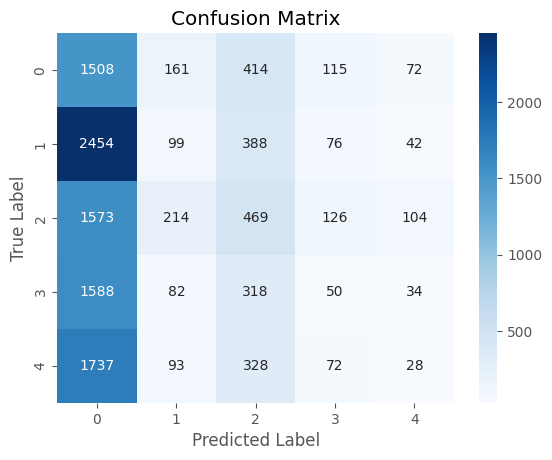

In [ ]:
# Confusion Matrix

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.17      0.66      0.27      2270
           1       0.15      0.03      0.05      3059
           2       0.24      0.19      0.21      2486
           3       0.11      0.02      0.04      2072
           4       0.10      0.01      0.02      2258

    accuracy                           0.18     12145
   macro avg       0.16      0.18      0.12     12145
weighted avg       0.16      0.18      0.12     12145



## Testing the mix of reliable and unrelable samples

In [ ]:
features = np.vstack((reliable_data_features, unreliable_data_features))
labels = np.concatenate((reliable_data_labels, unreliable_data_labels))

print("Unreliable data Class distribution:", Counter(labels))
print("Combined data features shape", features.shape)
print("Combined data labels shape", labels.shape)

Unreliable data Class distribution: Counter({0: 35853, 2: 6900, 1: 5442, 3: 2761, 4: 2614})
Combined data features shape (53570, 51200)
Combined data labels shape (53570,)


In [ ]:
np.save('data/experiments/experiment1/features.npy', features)
np.save('data/experiments/experiment1/labels.npy', labels)

In [ ]:
features = np.load('data/experiments/experiment1/features.npy')
labels = np.load('data/experiments/experiment1/labels.npy')

model = tf.keras.models.load_model('data/experiments/experiment1/model.h5')

In [ ]:
labels_cat = to_categorical(labels)

In [ ]:
loss, acc = model.evaluate(features, labels_cat)

print('Mixed data samples Accuracy:', acc)
print('Mixed data samples loss', loss)

1675/1675 [==============================] - 81s 48ms/step - loss: 3.8507 - accuracy: 0.7684
Mixed data samples Accuracy: 0.7683591842651367
Mixed data samples loss 3.850687265396118


In [ ]:
y_pred = model.predict(features)
y_pred = np.argmax(y_pred, axis=1)

y_test = np.argmax(labels_cat, axis=1)

1675/1675 [==============================] - 75s 45ms/step


In [ ]:
# Calculate precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the results
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

Accuracy: 0.7683591562441665
Precision: 0.748524258817194
Recall: 0.7683591562441665
F1 score: 0.7461745956017823


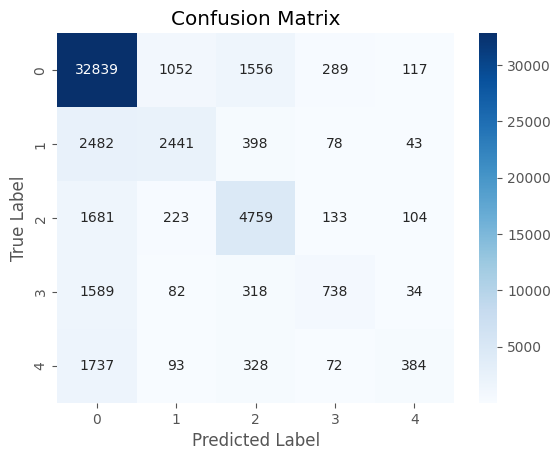

In [ ]:
# Confusion Matrix

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.92      0.86     35853
           1       0.63      0.45      0.52      5442
           2       0.65      0.69      0.67      6900
           3       0.56      0.27      0.36      2761
           4       0.56      0.15      0.23      2614

    accuracy                           0.77     53570
   macro avg       0.64      0.49      0.53     53570
weighted avg       0.75      0.77      0.75     53570

